## TestModelOverClusters_ControlledForSampleSize
This script:
- Reads in a pickle files which contains a dataframe with one row per sampled image. Each image is associated with a location (lat, lon), a link to the image_file, an embedding, category_scores, and the cluster the image has been assigned to with both 2 and 7 total clusters
- Reads in IMD data (for use in model fitting)
- Create subsamples of the dataframe from images in each cluster:
    - For each number of total clusters:
        - Takes N images for each cluster between [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]
        - If the cluster has less than N images, then it is capped at its maximum number of images
        - Store the results in a dictionary
- Fit a model with subsamples of that data:
    - For each number of total clusters:
        - For each cluster:
            - Fits a model using just the images within each sample size (if it has less samples than the sample size, then skip)

In [1]:
import pickle
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor

from joblib import Parallel, delayed

def is_missing_embedding(x):
    return isinstance(x, float) and np.isnan(x)

# Aggregation functions
def mean_embed(series):
    return np.mean(np.stack(series.values), axis=0)

from functions import *

In [2]:
data_dir = os.path.join("../../../../data/embeddings/")

In [3]:
k=7

### Get data

In [4]:
points_data_cache = data_dir + f"embeddings/one_row_per_image_cleaned_with_cluster_numbers.pkl"
with open(points_data_cache, "rb") as f:
    expanded_gdf = pickle.load(f)

In [5]:
# for num in range(1,8):
#     print(num)
#     print(len(expanded_gdf[expanded_gdf['scene_cluster_7']==num]))

In [6]:
# final_df = final_df.merge(lsoa_summary, on = "LSOA21CD")
# file_ending = f'kmeanscluster{k}_resampled1'
# final_df.to_pickle(data_dir + f"embedding_summaries/big_summary_df_{file_ending}.pkl")

### Read in IMD data

In [7]:
imd_file = os.path.join("../../../../", "data", "imd", "File_2_-_IoD2025_Domains_of_Deprivation.xlsx")
imd = pd.read_excel(imd_file, sheet_name="IoD2025 Domains", header=0)

# Rename columns to simpler versions
imd_col_map = {"LSOA code (2021)": "LSOA21CD",
    "Index of Multiple Deprivation (IMD) Rank (where 1 is most deprived)": "imd_rank",
    "Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)": "imd_decile"}
imd = imd.rename(columns=imd_col_map)

# Test model performance 


### Create a dictionary with random samples of the embedding points
In balanced_samples:  
- Each key is a sample size between 500 and 20000  
- Each item is a dataframe containing a random sample of rows from the dataframe  

In sampling_status:
- Each key is a sample size between 500 and 20000  
- Each item is a string stating whether the sample was fitted or capped (if there were <sample_size total images)    

In balanced_samples_master_dict and sampling_status_master_dict:  
- Each key is a number of clusters
- Each item is a copy of either the balanced_samples or sampling_status dict, for that number of clusters

In [111]:
# Specify the size of subsamples we wish to make
sample_sizes = [500,1000,2000,3000,4000,5000,6000,7000,10000,12500,15000,20000]

# Function to 
def sub_sample_data(df, cluster_col, n_per_cluster, random_state=None):
    """
    Take a sample from a dataframe by sampling up to
    n_per_cluster rows from each cluster.

    If a cluster has fewer than n_per_cluster rows, all rows
    from that cluster are used instead (i.e. the sample is capped).
    """

    # This inner function is applied separately to each cluster
    def sample_group(x):
        # x is the subset of df corresponding to one cluster
        # x.name is the cluster label (from groupby)

        # If the cluster is smaller than the requested sample size,
        # print a message so we know sampling was capped
        if len(x) < n_per_cluster:
            pass
            # print(f"Cluster {x.name}: capped at {len(x)} "
            #    f"(requested {n_per_cluster})")

        # Sample rows from this cluster:
        # - take n_per_cluster rows if possible
        # - otherwise take all available rows
        return x.sample(n=min(len(x), n_per_cluster), random_state=random_state)

    # Group the dataframe by cluster,
    # apply the sampling logic to each group,
    # then combine everything back into a single dataframe
    return (df.groupby(cluster_col, group_keys=False).apply(sample_group).reset_index(drop=True) )

# Dictionary to store results for each number of clusters
balanced_samples_master_dict = {}
sampling_status_master_dict = {}

cluster_numbers = range(2,11)
for cluster_number in cluster_numbers:
    
    # Variables to check whether cluster samples are capped or not.
    cluster_col = f"scene_cluster_{cluster_number}"
    cluster_sizes = expanded_gdf[cluster_col].value_counts()
    max_n = cluster_sizes.min()
    
    # Create dictionaries to store results
    balanced_samples = {}
    sampling_status = {}
    
    for sample_size in sample_sizes:

        # Create balanced sample
        balanced_samples[sample_size] = sub_sample_data(expanded_gdf,cluster_col, n_per_cluster=sample_size,random_state=42)

        # Record whether each cluster was capped or not
        sampling_status[sample_size] = {cluster: ("full" if cluster_sizes[cluster] >= sample_size else "capped")
                for cluster in cluster_sizes.index}
        
    balanced_samples_master_dict[cluster_number] = balanced_samples
    sampling_status_master_dict[cluster_number] = sampling_status
    
# Results check-up
# n=7
# np.unique(balanced_samples_master_dict[n][20000][f'scene_cluster_{n}'], return_counts=True)    

### Fit models using subsamples of the data for each cluster, and compare performance
- For each sample size between 500 and 20000:  
    - And each value of k between 2 and 10:
        - Run the model using just the embeddings for the images in each of the clusters

In [133]:
def fit_models_for_k_sample(k,sample_size,dictionary_of_results,dictionary_of_sampling_status,imd,
                            mean_embed, is_missing_embedding):
    
    category_column = f"scene_cluster_{k}"
    categories = range(1, k + 1)
    
    results = {}
    n_samples = {}   

    df = dictionary_of_results[k][sample_size]
    sampling_status = dictionary_of_sampling_status[k][sample_size]
    
    # ---- Compute mean embedding per LSOA per cluster ----
    per_cluster_dfs = [
        df[df[category_column] == cat]
        .groupby("LSOA21CD")["embedding"]
        .apply(mean_embed)
        .reset_index()
        .rename(columns={"embedding": f"{cat}_mean"})
        for cat in categories]

    final_df = reduce(
        lambda left, right: pd.merge(left, right, on="LSOA21CD", how="outer"),
        per_cluster_dfs)

    # ---- Join IMD ----
    final_df = final_df.merge(
        imd[["LSOA21CD", "imd_rank"]],
        on="LSOA21CD")
    final_df["imd_rerank"] = final_df["imd_rank"].rank(method="first").astype(int)

    # ---- Fit models per cluster ----
    for cluster_num in categories:
        print(cluster_num)

        if sampling_status.get(cluster_num) == "capped":
            results[cluster_num] = np.nan
            continue

        col = f"{cluster_num}_mean"
        df_cluster = final_df[["LSOA21CD", col, "imd_rerank"]].copy()

        df_cluster["missing"] = df_cluster[col].apply(is_missing_embedding).astype(int)
        df_cluster = df_cluster[df_cluster["missing"] == 0]

        if len(df_cluster) < 5:
            results[cluster_num] = np.nan
            continue

        X = np.stack(df_cluster[col].values)
        y = df_cluster["imd_rerank"].values

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        rf = RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=1)

        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)

        results[cluster_num] = r2_score(y_test, y_pred)

    return k, sample_size, results, n_samples


### Plot the results

In [143]:
# k_values = range(2, 11)
# n_jobs = 16

# outputs = Parallel(n_jobs=n_jobs, verbose=10)(
#     delayed(fit_models_for_k_sample)(
#         k,
#         sample_size,
#         balanced_samples_master_dict,
#         sampling_status_master_dict,
#         imd,
#         mean_embed,
#         is_missing_embedding)
#     for k in k_values
#         for sample_size in sample_sizes)

# ---- Assemble final results dict ----
results = {}
sample_counts = {}

for k, sample_size, cluster_results, n_samples in outputs:

    results.setdefault(k, {})
    sample_counts.setdefault(k, {})

    for cluster_num in cluster_results:
        results[k].setdefault(cluster_num, {})[sample_size] = cluster_results[cluster_num]
        # sample_counts[k].setdefault(cluster_num, {})[sample_size] = n_samples[cluster_num]


# # Assemble results from outputs
# for k, sample_size, cluster_results in outputs:
#     if k not in results:
#         results[k] = {}
#     for cluster_num, r2 in cluster_results.items():
#         results[k].setdefault(cluster_num, {})[sample_size] = r2


In [144]:
results = {}
sample_counts = {}

for k, sample_size, cluster_results, n_samples in outputs:

    results.setdefault(k, {})
    sample_counts.setdefault(k, {})

    for cluster_num in cluster_results:
        results[k].setdefault(cluster_num, {})[sample_size] = cluster_results[cluster_num]
        # sample_counts[k].setdefault(cluster_num, {})[sample_size] = n_samples[cluster_num]

In [147]:
### Save the results        
with open(data_dir + 'model_testing/results_dict_plotting_14thJan.pkl', "wb") as f:
    pickle.dump(results, f)
with open(data_dir + 'model_testing/results_dict_plotting_14thJan.pkl', "rb") as f:
    results_test = pickle.load(f)

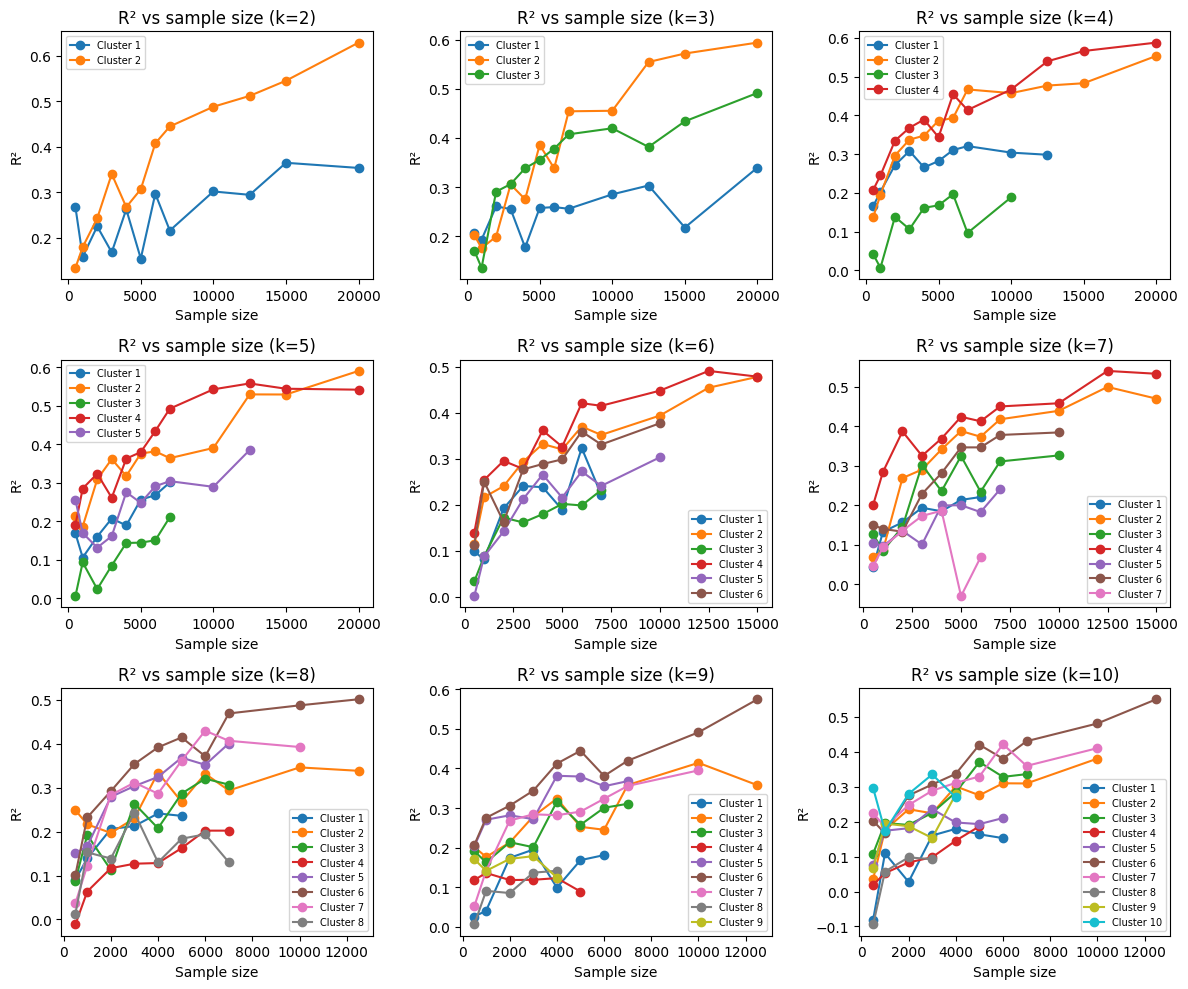

In [145]:
fig,axs=plt.subplots(ncols=3,nrows=3, figsize=(12,10))
axs=axs.flatten()
for ax_num, k in enumerate(range(2,11)):
    for cluster_num, sample_dict in results[k].items():
        x, y = zip(*sorted(sample_dict.items()))
        axs[ax_num].plot(x, y, marker='o', label=f"Cluster {cluster_num}")

    axs[ax_num].set_xlabel("Sample size")
    axs[ax_num].set_ylabel("R²")
    axs[ax_num].set_title(f"R² vs sample size (k={k})")
    axs[ax_num].legend(fontsize=7)
fig.tight_layout()